# ML Test: Modelos Predictivos de Clasificación Binaria de Clic sobre anuncio mediante técnicas de Aprendizaje Supervisado

Diego F. Osorio 

Machine Learning Engineer
MSc in Electronics and Computer Science (AI)

**Universidad de los Andes**

* Introducción
* Exploración
* ML Pipelines
* Evaluación
* Predicciones
* Conclusiones

# Librerias

In [371]:
# general
import numpy as np
import pandas as pd
import re
import os
import joblib
import pandas as pd
import random
import scipy.stats as stats
import pylab

# funciones
from funciones.data_exploration import explore
from funciones.feature_cleaning import missing_data, outlier, rare_values
from funciones.feature_cleaning import missing_data as ms
from funciones.feature_cleaning import outlier as ot
from funciones.feature_cleaning import rare_values as ra
from funciones.feature_engineering import discretization as dc
from funciones.feature_engineering import discretization, encoding, transformation
from funciones.feature_selection import embedded_method, feature_shuffle, filter_method, hybrid


# visualización
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import warn
from pandas.plotting import scatter_matrix
plt.style.use('seaborn-colorblind')
#from data_exploration import explore


# preprocesamiento
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif,chi2
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import KBinsDiscretizer


# ML
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

# metricas de evaluacion
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, confusion_matrix 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error 
from sklearn.metrics import classification_report


# autoML H2O
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator # importar h2o GLM elastic net
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from h2o.grid.grid_search import H2OGridSearch
# crear cluster de h2o
h2o.init(nthreads = 3, max_mem_size = 8)

# autoML TPOT
from tpot import TPOTClassifier


# ML pipelines
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics.pairwise import rbf_kernel


from sklearn import set_config



Checking whether there is an H2O instance running at http://localhost:54321.

C:\Users\Diego\AppData\Local\Temp\ipykernel_3088\166489922.py:28: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


 connected.


H2O_cluster_uptime:,1 min 46 secs
H2O_cluster_timezone:,America/Bogota
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.2
H2O_cluster_version_age:,1 month and 3 days
H2O_cluster_name:,H2O_from_python_Diego_5l00il
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


# Generar Base de datos

In [322]:
# Number of samples
n_samples = 1000

# Generate the sample data
data = {
    'copy': [random.choice(["50% off!", "Buy now!", "Limited offer!", "Best in town!", "Hurry up!", "Don't miss out!"]) for _ in range(n_samples)],
    'audience': [random.choice(["teens", "adults", "parents", "students", "elderly"]) for _ in range(n_samples)],
    'keywords': [random.choice(["sale", "discount", "offer", "limited", "exclusive", "bestseller"]) for _ in range(n_samples)],
    'time_of_day': [random.choice([i for i in range(24)]) for _ in range(n_samples)],  # 0 to 23 representing hours
    'clicked': [random.choice([0, 1]) for _ in range(n_samples)]
}

# Convert dictionary to DataFrame
df = pd.DataFrame(data)

# Add some intentional patterns
for i in range(n_samples):
    if df.at[i, 'audience'] == 'elderly' and df.at[i, 'copy'] == "Hurry up!":
        df.at[i, 'clicked'] = 0  # Elderly audience might not respond well to a 'Hurry up!' message
    
    if df.at[i, 'time_of_day'] >= 6 and df.at[i, 'time_of_day'] <= 11 and df.at[i, 'keywords'] == 'sale':
        df.at[i, 'clicked'] = 1  # More people might click on 'sale' keyword ads in the morning hours

# Save the dataset to a CSV file
df.to_csv("data/ad_data.csv", index=False)

df

,copy,audience,keywords,time_of_day,clicked
0,Buy now!,teens,exclusive,1,0
1,Buy now!,students,limited,9,1
2,Buy now!,teens,exclusive,8,1
3,Limited offer!,students,limited,17,1
4,50% off!,parents,bestseller,20,0
...,...,...,...,...,...
995,Limited offer!,teens,offer,21,1
996,Buy now!,adults,discount,4,1
997,Hurry up!,students,offer,0,1
998,Buy now!,elderly,offer,9,1


# Modelo Base: XGBoost default

In [323]:
### CORRER SOLO SI SE QUIERE VER EL ERROR

""" import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

data = pd.read_csv("data/ad_data.csv")

X = data.drop('clicked', axis=1)
y = data['clicked']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}") """

' import pandas as pd\nfrom xgboost import XGBClassifier\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import accuracy_score, roc_auc_score\n\ndata = pd.read_csv("data/ad_data.csv")\n\nX = data.drop(\'clicked\', axis=1)\ny = data[\'clicked\']\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\nmodel = XGBClassifier()\nmodel.fit(X_train, y_train)\n\ny_pred = model.predict(X_test)\n\nprint(f"Accuracy: {accuracy_score(y_test, y_pred)}") '

# Explicación del Error

El error en el código se debe a que se está intentado entrenar el modelo de ML XGBoost con variables (columnas) categóricas que todavía no se han preprocesado (codificado), por lo que el modelo no puede entrenarse correctamente. A continuación, se presenta el código corregido

In [324]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

data = pd.read_csv("data/ad_data.csv")

X = data.drop('clicked', axis=1)
y = data['clicked']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# codificar variables en datos de entrenamiento y prueba
# codificación one-hot [0-1] para poder procesar las variables categóricas
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")


Accuracy: 0.515


# Preprocesamiento

In [325]:
# crear copia de base de datos sin preprocesar
data_copy = df.copy(deep=True)
data_copy

,copy,audience,keywords,time_of_day,clicked
0,Buy now!,teens,exclusive,1,0
1,Buy now!,students,limited,9,1
2,Buy now!,teens,exclusive,8,1
3,Limited offer!,students,limited,17,1
4,50% off!,parents,bestseller,20,0
...,...,...,...,...,...
995,Limited offer!,teens,offer,21,1
996,Buy now!,adults,discount,4,1
997,Hurry up!,students,offer,0,1
998,Buy now!,elderly,offer,9,1


## Dividir base de datos en datos de entrenamiento y datos de prueba


In [326]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns='clicked'), df['clicked'], test_size=0.2, random_state=42)
x_train

,copy,audience,keywords,time_of_day
29,Best in town!,adults,offer,18
535,Best in town!,adults,offer,19
695,50% off!,students,offer,13
557,Limited offer!,elderly,offer,4
836,Best in town!,elderly,sale,2
...,...,...,...,...
106,50% off!,teens,discount,5
270,Hurry up!,elderly,sale,22
860,Buy now!,teens,discount,14
435,Buy now!,parents,discount,4


## Limpieza de datos

In [327]:
# calcular porcentaje de NAs y NULLs en cada columna
porcentaje_missing = df.isna().mean() * 100
porcentaje_null = df.isna().mean() * 100

# Sort the variables by missing percentage in descending order
porcentaje_missing.sort_values(ascending=False, inplace=True)
porcentaje_null.sort_values(ascending=False, inplace=True)

# ver the variables with missing percentage
print('porcentaje missing NA',porcentaje_missing)
print('porcentaje NULL NULL',porcentaje_null)

# no hay NA/NULL en base de datos

porcentaje missing NA copy           0.0
audience       0.0
keywords       0.0
time_of_day    0.0
clicked        0.0
dtype: float64
porcentaje NULL NULL copy           0.0
audience       0.0
keywords       0.0
time_of_day    0.0
clicked        0.0
dtype: float64


## Codificación

In [328]:
# one-hot encoding [0-1]
# crear columnas [0-1] para variables categoricas
x_train = pd.get_dummies(x_train, drop_first=True)
x_train


,time_of_day,copy_Best in town!,copy_Buy now!,copy_Don't miss out!,copy_Hurry up!,copy_Limited offer!,audience_elderly,audience_parents,audience_students,audience_teens,keywords_discount,keywords_exclusive,keywords_limited,keywords_offer,keywords_sale
29,18,1,0,0,0,0,0,0,0,0,0,0,0,1,0
535,19,1,0,0,0,0,0,0,0,0,0,0,0,1,0
695,13,0,0,0,0,0,0,0,1,0,0,0,0,1,0
557,4,0,0,0,0,1,1,0,0,0,0,0,0,1,0
836,2,1,0,0,0,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,5,0,0,0,0,0,0,0,0,1,1,0,0,0,0
270,22,0,0,0,1,0,1,0,0,0,0,0,0,0,1
860,14,0,1,0,0,0,0,0,0,1,1,0,0,0,0
435,4,0,1,0,0,0,0,1,0,0,1,0,0,0,0


In [329]:
# one-hot encoding [0-1]
# crear columnas [0-1] para variables categoricas
x_test = pd.get_dummies(x_test, drop_first=True)
x_test


,time_of_day,copy_Best in town!,copy_Buy now!,copy_Don't miss out!,copy_Hurry up!,copy_Limited offer!,audience_elderly,audience_parents,audience_students,audience_teens,keywords_discount,keywords_exclusive,keywords_limited,keywords_offer,keywords_sale
521,23,1,0,0,0,0,0,0,1,0,0,1,0,0,0
737,20,0,0,1,0,0,1,0,0,0,0,1,0,0,0
740,12,0,0,0,1,0,1,0,0,0,0,0,1,0,0
660,3,0,0,0,1,0,0,0,0,1,0,1,0,0,0
411,14,0,0,0,0,1,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,16,0,1,0,0,0,0,0,1,0,0,1,0,0,0
332,2,0,1,0,0,0,0,0,0,0,1,0,0,0,0
208,8,0,0,0,1,0,1,0,0,0,0,0,0,0,1
613,7,0,0,1,0,0,1,0,0,0,0,0,0,0,0


## Discretización de Variable Numérica

In [330]:
# crear discretizador por DecisionTree para escoger split óptimo 
enc1 = dc.DiscretizeByDecisionTree(col='time_of_day',max_depth=2).fit(X=x_train,y=y_train )
enc1.tree_model
enc1

In [331]:
x_train.columns

Index(['time_of_day', 'copy_Best in town!', 'copy_Buy now!',
       'copy_Don't miss out!', 'copy_Hurry up!', 'copy_Limited offer!',
       'audience_elderly', 'audience_parents', 'audience_students',
       'audience_teens', 'keywords_discount', 'keywords_exclusive',
       'keywords_limited', 'keywords_offer', 'keywords_sale'],
      dtype='object')

In [332]:
# discretizar variables numéricas con discretizador por DecisionTree
x_train = enc1.transform(x_train)
x_test = enc1.transform(x_test)

# quitar variable original
x_train = x_train.drop(columns='time_of_day')
x_test = x_test.drop(columns='time_of_day')
x_train

,copy_Best in town!,copy_Buy now!,copy_Don't miss out!,copy_Hurry up!,copy_Limited offer!,audience_elderly,audience_parents,audience_students,audience_teens,keywords_discount,keywords_exclusive,keywords_limited,keywords_offer,keywords_sale,time_of_day_tree_discret
29,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.466667
535,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.466667
695,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0.466667
557,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0.537604
836,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0.346154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0.537604
270,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0.466667
860,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0.466667
435,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0.537604


In [333]:
x_train

,copy_Best in town!,copy_Buy now!,copy_Don't miss out!,copy_Hurry up!,copy_Limited offer!,audience_elderly,audience_parents,audience_students,audience_teens,keywords_discount,keywords_exclusive,keywords_limited,keywords_offer,keywords_sale,time_of_day_tree_discret
29,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.466667
535,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.466667
695,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0.466667
557,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0.537604
836,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0.346154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0.537604
270,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0.466667
860,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0.466667
435,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0.537604


In [334]:
x_test

,copy_Best in town!,copy_Buy now!,copy_Don't miss out!,copy_Hurry up!,copy_Limited offer!,audience_elderly,audience_parents,audience_students,audience_teens,keywords_discount,keywords_exclusive,keywords_limited,keywords_offer,keywords_sale,time_of_day_tree_discret
521,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0.466667
737,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0.466667
740,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0.537604
660,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0.537604
411,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0.466667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0.466667
332,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0.346154
208,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0.537604
613,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.537604


## Tratamiento de datos desbalanceados

In [335]:
# crear nueva base
# SMOTE() crear clase que hacer oversampling
sm = SMOTE(sampling_strategy='auto', random_state=1, k_neighbors=5, n_jobs=-1)

# crear nuevas bases con oversampling 
# convertir variables a DataFrame
x_train, y_train = sm.fit_resample(x_train, y_train)
x_train = pd.DataFrame(x_train, columns = x_train.columns)

x_test, y_test = sm.fit_resample(x_test, y_test)
x_test = pd.DataFrame(x_test, columns = x_test.columns)

x_train

c:\Users\Diego\anaconda3\Lib\site-packages\imblearn\over_sampling\_smote\base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
c:\Users\Diego\anaconda3\Lib\site-packages\imblearn\over_sampling\_smote\base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


,copy_Best in town!,copy_Buy now!,copy_Don't miss out!,copy_Hurry up!,copy_Limited offer!,audience_elderly,audience_parents,audience_students,audience_teens,keywords_discount,keywords_exclusive,keywords_limited,keywords_offer,keywords_sale,time_of_day_tree_discret
0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.466667
1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.466667
2,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0.466667
3,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0.537604
4,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0.346154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0.537604
808,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.466667
809,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0.514228
810,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.537604


0    0.5
1    0.5
Name: clicked, dtype: float64

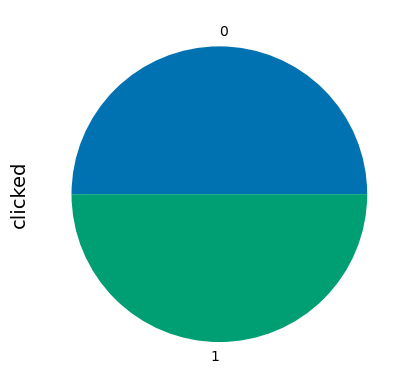

In [336]:
# value_counts().plot(kind='pie'):  hacer conteo de clases y plot tipo 'pie'
y_train.value_counts().plot(kind='pie')
y_train.value_counts(normalize=True)

0    0.5
1    0.5
Name: clicked, dtype: float64

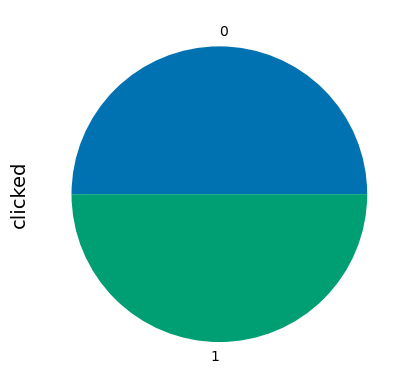

In [337]:
# value_counts().plot(kind='pie'):  hacer conteo de clases y plot tipo 'pie'
y_test.value_counts().plot(kind='pie')
y_test.value_counts(normalize=True)

In [338]:
x_train

,copy_Best in town!,copy_Buy now!,copy_Don't miss out!,copy_Hurry up!,copy_Limited offer!,audience_elderly,audience_parents,audience_students,audience_teens,keywords_discount,keywords_exclusive,keywords_limited,keywords_offer,keywords_sale,time_of_day_tree_discret
0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.466667
1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.466667
2,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0.466667
3,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0.537604
4,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0.346154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0.537604
808,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.466667
809,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0.514228
810,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.537604


In [339]:
x_test

,copy_Best in town!,copy_Buy now!,copy_Don't miss out!,copy_Hurry up!,copy_Limited offer!,audience_elderly,audience_parents,audience_students,audience_teens,keywords_discount,keywords_exclusive,keywords_limited,keywords_offer,keywords_sale,time_of_day_tree_discret
0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0.466667
1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0.466667
2,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0.537604
3,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0.537604
4,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0.466667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.466667
218,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0.507732
219,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.537604
220,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.346154


## Estandarización

In [318]:
# guardar columnas de variables para DataFrame
cols_train =  x_train.columns
cols_test =  x_test.columns


In [342]:
# crear escalador Estandar
# ajustar escalador con datos de entrenamiento
escalador = StandardScaler()
escalador.fit(x_train[['time_of_day_tree_discret']])

# transformar variables x con escalador entrenado con datos de entrenamiento
x_train['time_of_day_tree_discret'] = escalador.transform(x_train[['time_of_day_tree_discret']])
x_test['time_of_day_tree_discret'] = escalador.transform(x_test[['time_of_day_tree_discret']])

# convertir variables a DataFrame
x_train = pd.DataFrame(x_train, columns = cols_train)
x_test = pd.DataFrame(x_test, columns = cols_test)


,copy_Best in town!,copy_Buy now!,copy_Don't miss out!,copy_Hurry up!,copy_Limited offer!,audience_elderly,audience_parents,audience_students,audience_teens,keywords_discount,keywords_exclusive,keywords_limited,keywords_offer,keywords_sale,time_of_day_tree_discret
0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.567972
1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.567972
2,0,0,0,0,0,0,0,1,0,0,0,0,1,0,-0.567972
3,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0.975402
4,1,0,0,0,0,1,0,0,0,0,0,0,0,1,-3.189937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0.975402
808,1,0,0,0,0,0,0,1,0,0,0,0,0,0,-0.567972
809,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0.466810
810,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.975402


In [344]:
x_train

,copy_Best in town!,copy_Buy now!,copy_Don't miss out!,copy_Hurry up!,copy_Limited offer!,audience_elderly,audience_parents,audience_students,audience_teens,keywords_discount,keywords_exclusive,keywords_limited,keywords_offer,keywords_sale,time_of_day_tree_discret
0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.567972
1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.567972
2,0,0,0,0,0,0,0,1,0,0,0,0,1,0,-0.567972
3,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0.975402
4,1,0,0,0,0,1,0,0,0,0,0,0,0,1,-3.189937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0.975402
808,1,0,0,0,0,0,0,1,0,0,0,0,0,0,-0.567972
809,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0.466810
810,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.975402


In [343]:
x_test

,copy_Best in town!,copy_Buy now!,copy_Don't miss out!,copy_Hurry up!,copy_Limited offer!,audience_elderly,audience_parents,audience_students,audience_teens,keywords_discount,keywords_exclusive,keywords_limited,keywords_offer,keywords_sale,time_of_day_tree_discret
0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,-0.567972
1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,-0.567972
2,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0.975402
3,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0.975402
4,0,0,0,0,1,0,0,1,0,1,0,0,0,0,-0.567972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.567972
218,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0.325475
219,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.975402
220,1,0,0,0,0,0,0,0,0,0,0,0,1,0,-3.189937


## Guardar Bases de Datos

In [348]:
# base de datos de entrenamiento
x_train.to_csv('data/x_train.csv')
y_train.to_csv('data/y_train.csv')

# base de datos de prueba
x_test.to_csv('data/x_test.csv')
y_test.to_csv('data/y_test.csv')


# Exploración

* Análisis Descriptivo
* Análisis Estadístico
* Visualización
* Técnicas de correlación
* Aprendizaje no Supervisado

## Análisis Descriptivo

In [107]:
x

,copy_Best in town!,copy_Buy now!,copy_Don't miss out!,copy_Hurry up!,copy_Limited offer!,audience_elderly,audience_parents,audience_students,audience_teens,keywords_discount,keywords_exclusive,keywords_limited,keywords_offer,keywords_sale,time_of_day_tree_discret
0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0.421622
1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0.568182
2,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0.421622
3,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0.513393
4,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0.421622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1013,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0.513393
1014,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.557358
1015,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0.513393
1016,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0.434664


In [108]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   copy_Best in town!        1018 non-null   uint8  
 1   copy_Buy now!             1018 non-null   uint8  
 2   copy_Don't miss out!      1018 non-null   uint8  
 3   copy_Hurry up!            1018 non-null   uint8  
 4   copy_Limited offer!       1018 non-null   uint8  
 5   audience_elderly          1018 non-null   uint8  
 6   audience_parents          1018 non-null   uint8  
 7   audience_students         1018 non-null   uint8  
 8   audience_teens            1018 non-null   uint8  
 9   keywords_discount         1018 non-null   uint8  
 10  keywords_exclusive        1018 non-null   uint8  
 11  keywords_limited          1018 non-null   uint8  
 12  keywords_offer            1018 non-null   uint8  
 13  keywords_sale             1018 non-null   uint8  
 14  time_of_

In [109]:
# contar observaciones(fila) por clase de variable
y.value_counts()

1    509
0    509
Name: clicked, dtype: int64

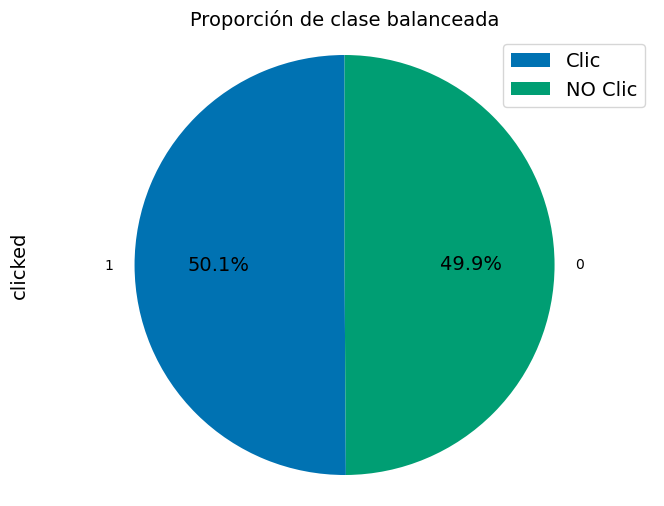

In [224]:
# calcular proporcion de clase

# variable y dependiente (target)
# y= 'clicked'
y.value_counts()
# calcular proporcion de clases
class_proportions = y.value_counts(normalize=True)

# crear pie plot
plt.figure(figsize=(8, 6))
class_proportions.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Proporción de clase balanceada')
plt.legend(labels=['Clic','NO Clic'], loc='best')
plt.axis('equal')

# Show the plot
plt.show()

1    0.501
0    0.499
Name: clicked, dtype: float64

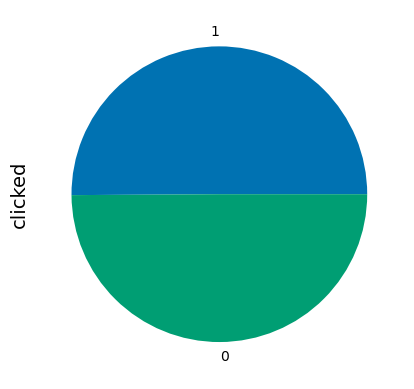

In [225]:
# distribucion de clases
# 1=clic, 0=no clic
y.value_counts().plot(kind='pie')
y.value_counts(normalize=True)

In [226]:
# análisis estadístico preliminar para variables numéricas
# contar observaciones(filas) por variable
# promedio, desviacion estandar
# valor máximo, mínnimo y cuantiles por columna (variable)

x.describe()

,copy_Best in town!,copy_Buy now!,copy_Don't miss out!,copy_Hurry up!,copy_Limited offer!,audience_elderly,audience_parents,audience_students,audience_teens,keywords_discount,keywords_exclusive,keywords_limited,keywords_offer,keywords_sale,time_of_day_tree_discret
count,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000
mean,0.161100,0.170923,0.179764,0.154224,0.159136,0.182711,0.215128,0.216110,0.200393,0.181729,0.149312,0.158153,0.175835,0.170923,0.491021
std,0.367804,0.376627,0.384180,0.361341,0.365982,0.386620,0.411113,0.411792,0.400491,0.385810,0.356571,0.365064,0.380867,0.376627,0.057777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.421622
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.421622
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.513393
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.513393
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.585106


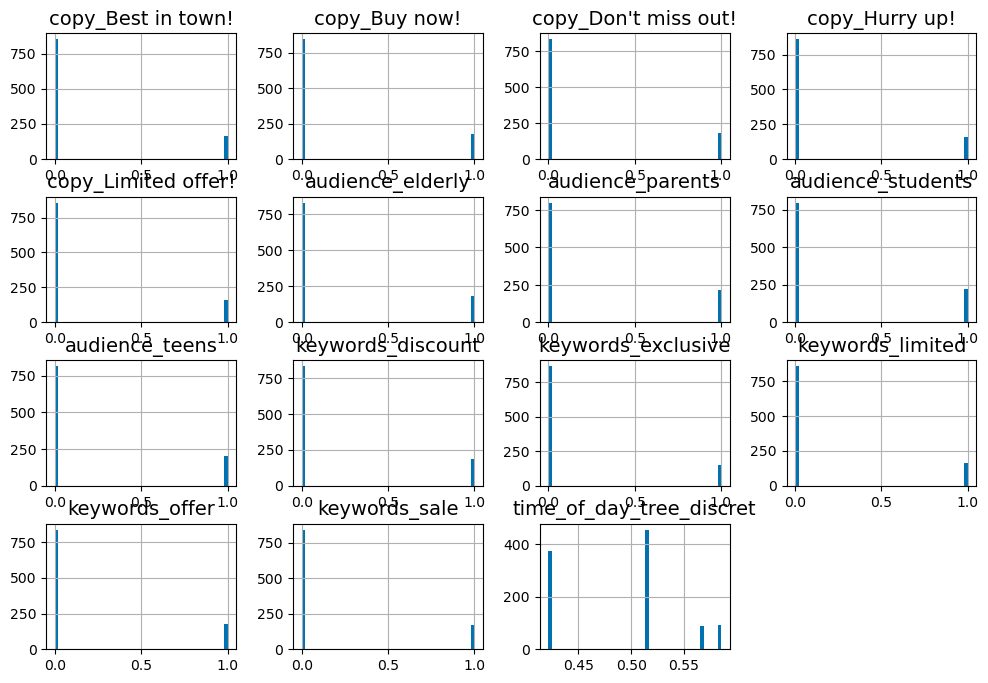

In [238]:
# Plot hisogramas de distrubucion de variables numéricas en base de datos
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

x.hist(bins=50, figsize=(12, 8))
plt.show()


## Análisis Estadístico

## Visualización

Image saved at ./data/Barplot_audience_clicked.png


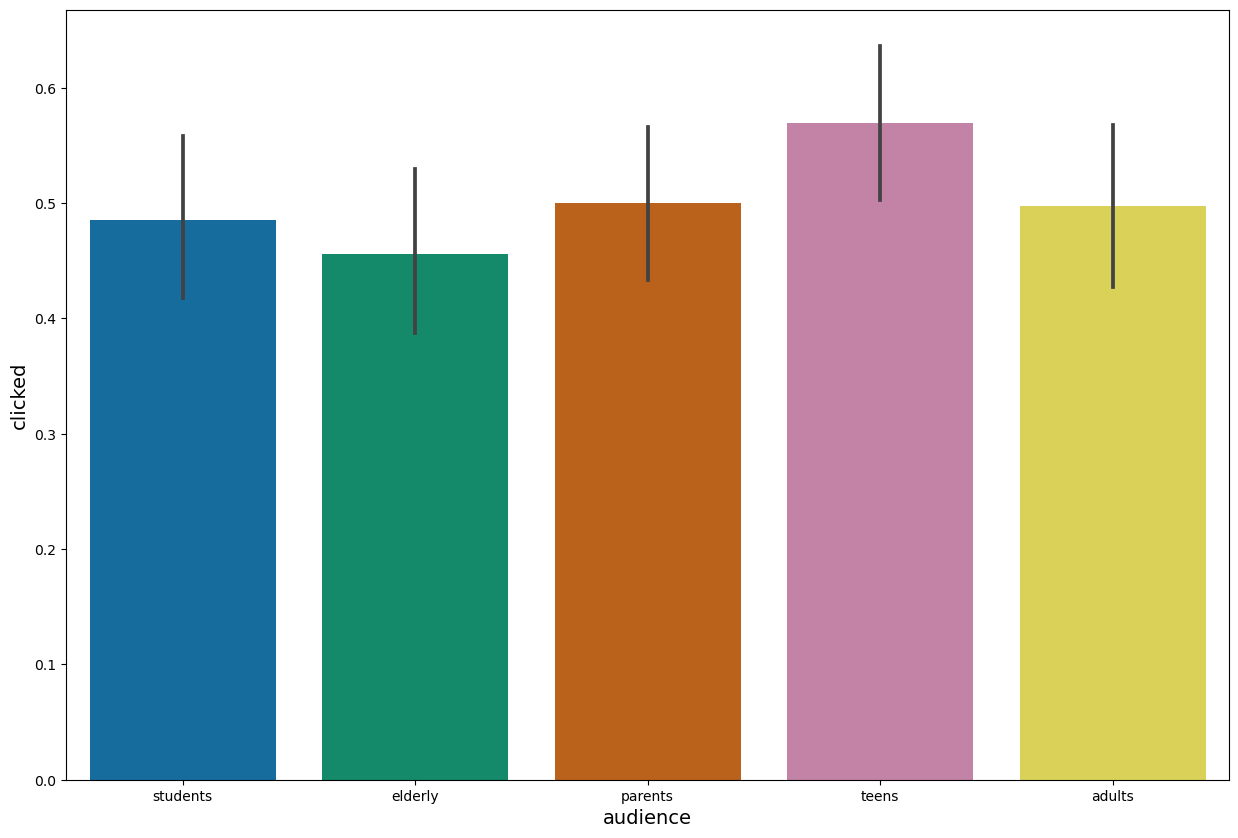

In [228]:
# gráfico de barra  
# y 'clicked' vs. 'audience'
explore.discrete_var_barplot(x='audience',y='clicked',data=data_copy,output_path='./data/')

Image saved at ./data\Countplot_clicked.png


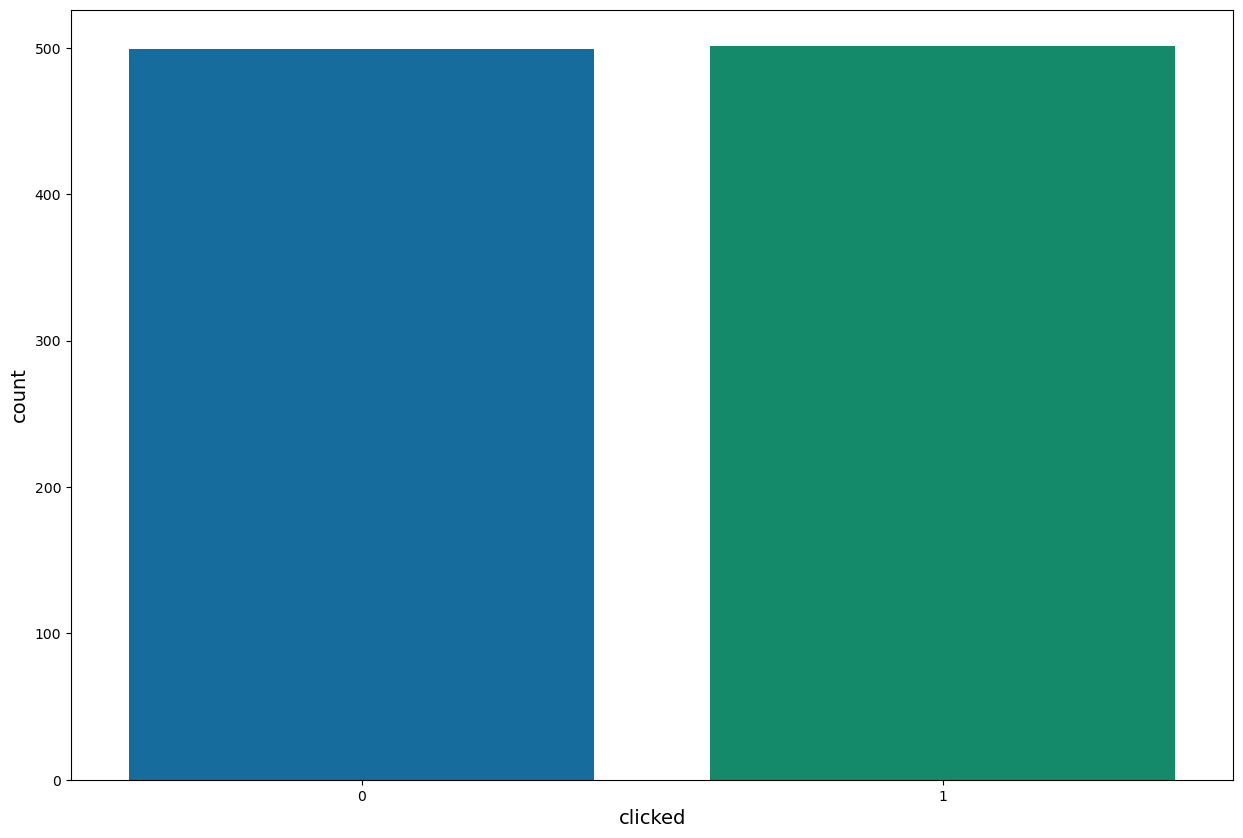

In [229]:
# count plot: contar observaciones por categoria en columna 
# x= 'clicked'
explore.discrete_var_countplot(x='clicked',data=data_copy,output_path='./data')

Image saved at ./data\Boxplot_audience_clicked.png


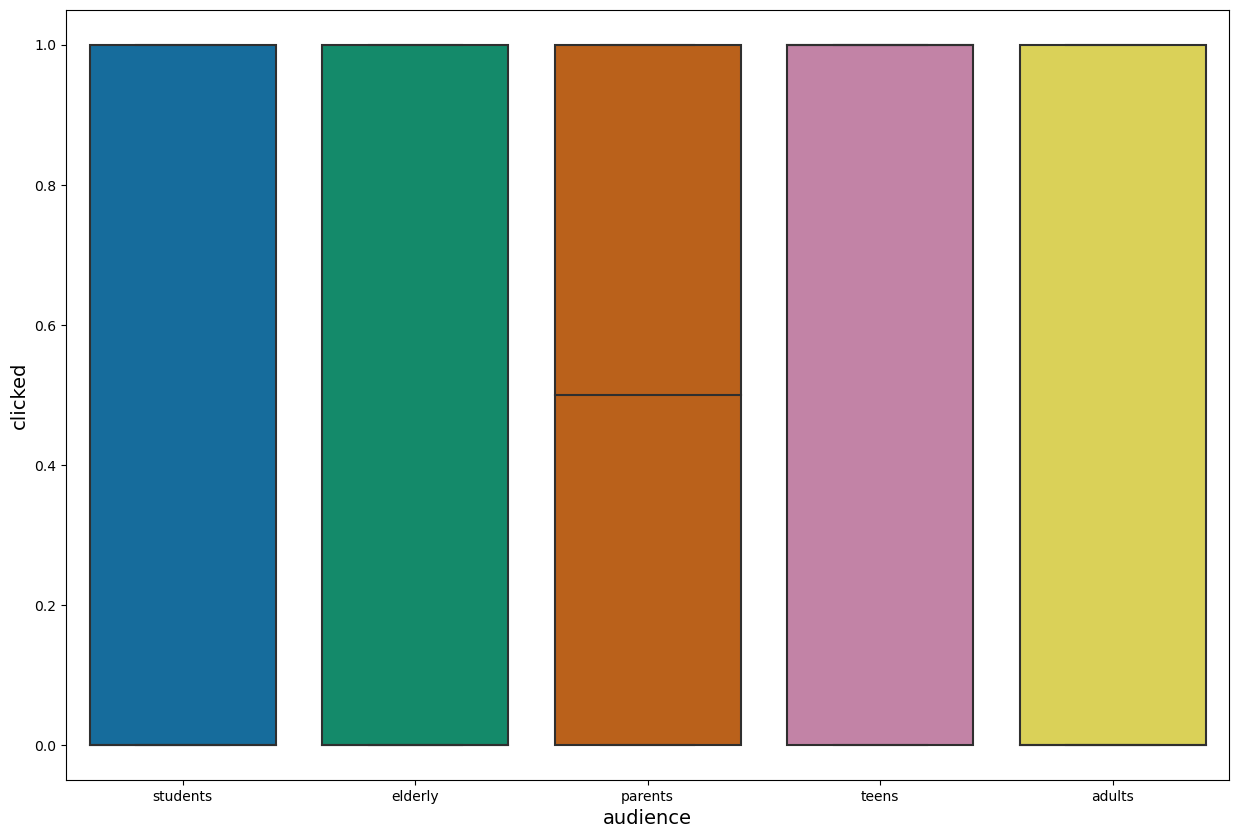

In [230]:
# box plot 
# y 'clicked' vs. x 'audience'
explore.discrete_var_boxplot(x='audience',y='clicked',data=data_copy,output_path='./data')

## Técnicas de Correlación

In [243]:
# crear matriz de correlación entre variables numericas en base de datos 
x_corr = x
x_corr['clicked'] = y
corr_matrix =x_corr.corr()
corr_matrix

x_corr

,copy_Best in town!,copy_Buy now!,copy_Don't miss out!,copy_Hurry up!,copy_Limited offer!,audience_elderly,audience_parents,audience_students,audience_teens,keywords_discount,keywords_exclusive,keywords_limited,keywords_offer,keywords_sale,time_of_day_tree_discret,clicked
0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0.421622,0.0
1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0.568182,0.0
2,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0.421622,0.0
3,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0.513393,0.0
4,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0.421622,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1013,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0.513393,NaN
1014,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.557358,NaN
1015,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0.513393,NaN
1016,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0.434664,NaN


In [242]:
# correlación con 'variable ' especifica target
corr_matrix["clicked"].sort_values(ascending=False)

clicked                     1.000000
audience_teens              0.066371
copy_Hurry up!              0.054556
audience_parents            0.020781
keywords_sale               0.017684
copy_Limited offer!         0.015494
copy_Best in town!          0.007239
keywords_discount           0.001640
keywords_offer             -0.000931
time_of_day_tree_discret   -0.005268
copy_Buy now!              -0.008876
audience_elderly           -0.026656
keywords_exclusive         -0.034627
audience_students          -0.040056
keywords_limited           -0.042095
copy_Don't miss out!       -0.047789
Name: clicked, dtype: float64

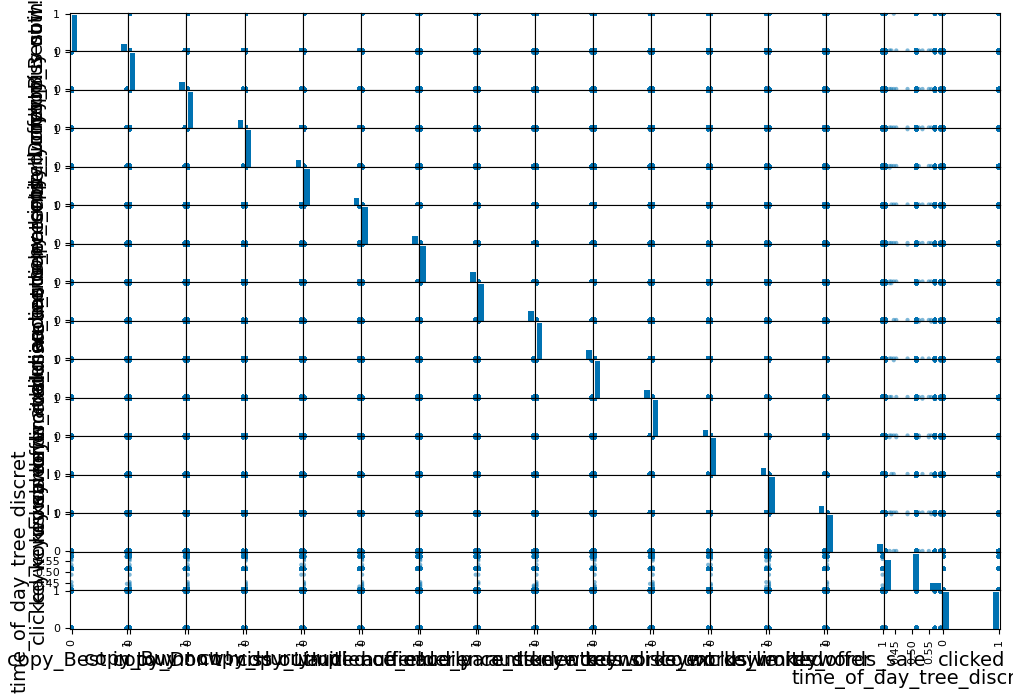

In [244]:
# Plot matriz de dispersion entre variables numéricas
# variables numericas: "time_of_day", "clicked"
#attributes = df.columns
scatter_matrix(x_corr[x_corr.columns], figsize=(12, 8))
plt.show()


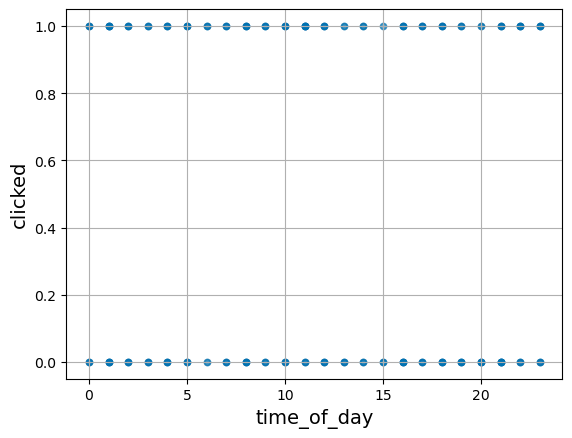

In [98]:
# gráfico de dispersión entre variables numéricas
df.plot(kind="scatter", x="time_of_day", y="clicked",
             alpha=0.1, grid=True)
plt.show()

Image saved at ./data/Corr_plot.png


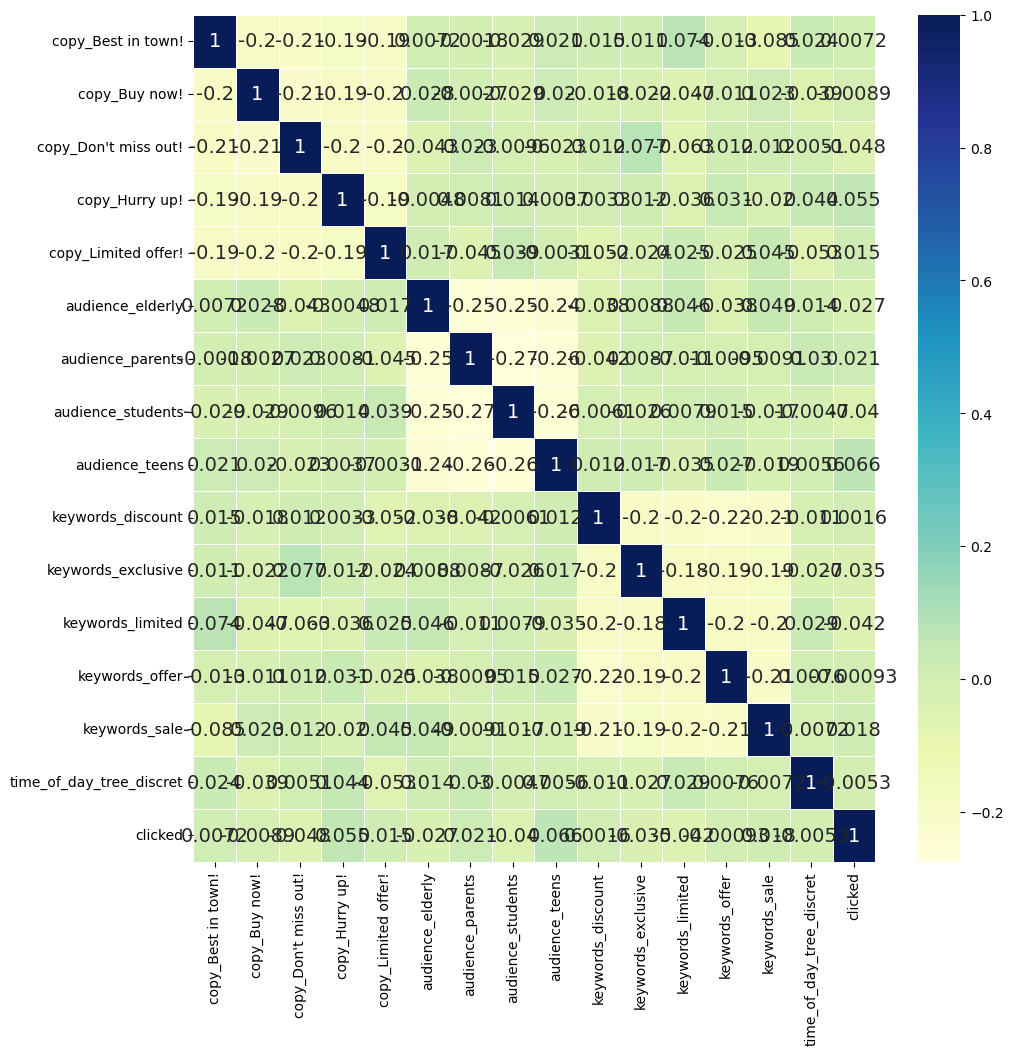

In [245]:
# gráfico de correlación entre columnas (variables) de DataFrame
explore.correlation_plot(data=x_corr,output_path='./data/')


# ML

In [364]:
# cargar bases de datos pre-procesadas
x_train = pd.read_csv('data/x_train.csv') 
y_train = pd.read_csv('data/y_train.csv')

x_test = pd.read_csv('data/x_test.csv')
y_test = pd.read_csv('data/y_test.csv')

# quitar primera columna
x_train.pop(x_train.columns[0])
y_train.pop(y_train.columns[0])
x_test.pop(x_test.columns[0])
y_test.pop(y_test.columns[0])


0        0
1        1
2        2
3        3
4        4
      ... 
217    217
218    218
219    219
220    220
221    221
Name: Unnamed: 0, Length: 222, dtype: int64

## GridSearch

Sintonizador de hiper-parámetros

In [393]:
# Sintonización de Hiperparámetros

# crear modelos de ML
lr = LogisticRegression(n_jobs=-1, random_state=100)
dt = DecisionTreeClassifier(splitter='best', random_state=100)
rf = RandomForestClassifier(n_jobs=-1, max_features = 3, verbose = 1, random_state=100)
ada = AdaBoostClassifier(random_state=100)
xgb = XGBClassifier(max_depth = 7, verbosity=3, random_state=100)
bagging = BaggingClassifier(n_estimators = 100, n_jobs=-1, random_state= 100, verbose = 3)


# grids de hiper parámetros de cada modelo
#Regresión Logística
para_lr = { 'penalty': ['l2'], 'C':np.linspace(0.01,50,num=20,dtype=float) }
grid_lr = GridSearchCV(lr, param_grid=para_lr, scoring= 'recall', n_jobs=-1, cv=5, verbose = 3)

#Árbol de Decisión
para_dt = { 'criterion': ['gini','entropy'], 'max_depth': np.linspace(1,50,num=5,dtype=int), 'min_samples_split': np.linspace(9,20,num=5,dtype=int), 'min_samples_leaf': np.linspace(1,100,num=5,dtype=int)}
grid_dt = GridSearchCV(dt, param_grid=para_dt, scoring= 'recall', n_jobs=-1, cv=5, verbose = 3)

#Random Forest
params_rf = {'n_estimators':np.linspace(100,500,num=3,dtype=int),'criterion':['gini'], 'max_depth': np.linspace(1,50,num=3,dtype=int), 'min_samples_split': np.linspace(9,20,num=3,dtype=int) }  # 'min_samples_leaf':np.linspace(2,30,num=3,dtype=int), 'max_features':[3,6,9], 'oob_score':[True,False]
grid_rf = GridSearchCV(rf, param_grid=params_rf, scoring= 'recall', n_jobs=-1, cv=5, verbose = 3)

#AdaBoost
params_ada = {'n_estimators':np.linspace(50,600,num=3,dtype=int), 'learning_rate':np.linspace(0.01,1,num=3,dtype=float) }
grid_ada =  GridSearchCV(ada, param_grid=params_ada, scoring= 'recall', n_jobs=-1, cv=5, verbose = 3)

#XGBoost
params_xgb = {'n_estimators':np.linspace(50,600,num=3,dtype=int), 'learning_rate':np.linspace(0.01,1,num=3,dtype=float)} # 'booster':['gbtree','dart']
rs_xgb =  RandomizedSearchCV(xgb, param_distributions=params_xgb, scoring= 'recall', n_jobs=-1, cv=5, verbose = 3)

#Bagging
params_bagg = { 'oob_score':[True,False] }
grid_bagg =  GridSearchCV(bagging, param_grid=params_bagg, scoring= 'recall', cv=5, verbose = 3)



In [395]:
x_train

,copy_Best in town!,copy_Buy now!,copy_Don't miss out!,copy_Hurry up!,copy_Limited offer!,audience_elderly,audience_parents,audience_students,audience_teens,keywords_discount,keywords_exclusive,keywords_limited,keywords_offer,keywords_sale,time_of_day_tree_discret
0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.567972
1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.567972
2,0,0,0,0,0,0,0,1,0,0,0,0,1,0,-0.567972
3,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0.975402
4,1,0,0,0,0,1,0,0,0,0,0,0,0,1,-3.189937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0.975402
808,1,0,0,0,0,0,0,1,0,0,0,0,0,0,-0.567972
809,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0.466810
810,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.975402


In [396]:
y_train

,clicked
0,0
1,1
2,0
3,0
4,0
...,...
807,1
808,1
809,1
810,1


## Entrenamiento

In [397]:
# ajustar/entrenar los optimizador de hiperparametros GridSearchCV de cada modelo
grid_lr.fit(x_train, y_train)
joblib.dump(grid_lr, 'data/models/grid_lr1.pkl')

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['data/models/grid_lr1.pkl']

In [398]:
grid_dt.fit(x_train, y_train)
joblib.dump(grid_dt, 'data/models/grid_dt.pkl')

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


['data/models/grid_dt.pkl']

In [399]:
grid_rf.fit(x_train, y_train)
joblib.dump(grid_rf, 'data/models/grid_rf.pkl')

Fitting 5 folds for each of 27 candidates, totalling 135 fits


c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.5s finished


['data/models/grid_rf.pkl']

In [400]:
grid_ada.fit(x_train, y_train)
joblib.dump(grid_ada, 'data/models/grid_ada.pkl')

Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['data/models/grid_ada.pkl']

In [401]:
rs_xgb.fit(x_train, y_train)
joblib.dump(rs_xgb, 'data/models/rs_xgb.pkl')

c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[12:25:26] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[12:25:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=7
[12:25:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=7
[12:25:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=7
[12:25:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=7
[12:25:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 80 extra nodes, 0 prune

['data/models/rs_xgb.pkl']

In [402]:
# ajustar/entrenar los optimizador de hiperparametros GridSearchCV de cada modelo
grid_bagg.fit(x_train, y_train)
joblib.dump(grid_bagg, 'data/models/grid_bagg.pkl')

Fitting 5 folds for each of 2 candidates, totalling 10 fits


c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out

[CV 1/5] END ....................oob_score=True;, score=0.519 total time=   0.1s


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


[CV 2/5] END ....................oob_score=True;, score=0.573 total time=   0.2s


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out

[CV 3/5] END ....................oob_score=True;, score=0.543 total time=   0.2s


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


[CV 4/5] END ....................oob_score=True;, score=0.556 total time=   0.1s


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out

[CV 5/5] END ....................oob_score=True;, score=0.531 total time=   0.2s
[CV 1/5] END ...................oob_score=False;, score=0.519 total time=   0.1s


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | 

[CV 2/5] END ...................oob_score=False;, score=0.573 total time=   0.1s
[CV 3/5] END ...................oob_score=False;, score=0.543 total time=   0.1s


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=8)]: Using backend Lok

[CV 4/5] END ...................oob_score=False;, score=0.556 total time=   0.0s
[CV 5/5] END ...................oob_score=False;, score=0.531 total time=   0.0s


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


['data/models/grid_bagg.pkl']

## Selección de Modelo

In [415]:
# extraer mejores modelos sintonizados para cada modelo
lr_op = grid_lr.best_estimator_
dt_op = grid_dt.best_estimator_
rf_op = grid_rf.best_estimator_
ada_op = grid_ada.best_estimator_
xgb_op = rs_xgb.best_estimator_
bagg_op = grid_bagg.best_estimator_

# extraer mejores métricas de evaluacion promedio (validacion cruzada) de cada modelo 
mean_lr_score = grid_lr.best_score_
mean_dt_score = grid_dt.best_score_
mean_rf_score = grid_rf.best_score_
mean_ada_score = grid_ada.best_score_
mean_xgb_score = rs_xgb.best_score_
mean_bagg_score = grid_bagg.best_score_


# print los mejores hiper parametros de cada modelo
print("Mejores score de Promedio K-Fold Regresión Logistica:", mean_lr_score)
print("Mejores score de Promedio K-Fold Árbol de Decisión:", mean_dt_score)
print("Mejores score de Promedio K-Fold Random Forest:", mean_rf_score)
print("Mejores score de Promedio K-Fold AdaBoost:", mean_ada_score)
print("Mejores score de Promedio K-Fold XGBoost:", mean_xgb_score)
print("Mejores score de Promedio K-Fold XGBoost:", mean_bagg_score)


# lista de mejores modelos de cada modelo 
classifiers = [('Regresión Logística', lr_op),
               ('Árbol de Decisión', dt_op), ('Random Forest', rf_op), ('AdaBoost', ada_op),
               ('Bagging', bagg_op), ('XGBoost', xgb_op)]

classifier_names = []


# crear listas de métricas de evaluacion

classifier_acc = []# (TP+TN)/TOT
classifier_rec = []# rec = 1-FNR
classifier_spec = []# spec = 1-FPR
classifier_prec= []# prec = 1-FDR
classifier_f1 = []# media armonica entre prec y rec

for classifier_name, classifier in classifiers:
 
    # ajustar modelo sintonizado con datos de entrenamiento
    classifier.fit(x_train, y_train)    
    
    # crear y_predict vector de predicciones
    y_predict = classifier.predict(x_test)
    
    # calcular matriz de confusion
    print(pd.DataFrame(confusion_matrix(y_test, y_predict)))
    print('')
    confusion = confusion_matrix(y_test, y_predict)    
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_predict ).ravel()
    spec = tn / (tn+fp)
    
    # calcular scoring = 'specificity'
    specificity = specificity1 = confusion[1,1]/(confusion[1,0]+confusion[1,1])
    
    # calcular métricas de evaluación
    accuracy = accuracy_score(y_test,y_predict)
    recall = recall_score(y_test,y_predict)
    precision = precision_score(y_test,y_predict)
    f1 = f1_score(y_test,y_predict)
    
    
    # Evaluación del clasificador
    print('{:s} : {:.2f}'.format(classifier_name, specificity))
    classifier_names.append(classifier_name)
    classifier_spec.append(specificity)
    
    print('{:s} : {:.2f}'.format(classifier_name, accuracy))
    classifier_acc.append(accuracy)
    
    print('{:s} : {:.2f}'.format(classifier_name, recall))
    classifier_rec.append(recall)
    
    print('{:s} : {:.2f}'.format(classifier_name, precision))
    classifier_prec.append(precision)
    
    print('{:s} : {:.2f}'.format(classifier_name, f1))
    classifier_f1.append(f1)





Mejores score de Promedio K-Fold Regresión Logistica: 0.5591388136103583
Mejores score de Promedio K-Fold Árbol de Decisión: 0.556910569105691
Mejores score de Promedio K-Fold Random Forest: 0.569015356820235
Mejores score de Promedio K-Fold AdaBoost: 0.5570912375790424
Mejores score de Promedio K-Fold XGBoost: 0.5962962962962963
Mejores score de Promedio K-Fold XGBoost: 0.5442637759710931


c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    0   1
0  68  43
1  49  62

Regresión Logística : 0.56
Regresión Logística : 0.59
Regresión Logística : 0.56
Regresión Logística : 0.59
Regresión Logística : 0.57
    0   1
0  64  47
1  56  55

Árbol de Decisión : 0.50
Árbol de Decisión : 0.54
Árbol de Decisión : 0.50
Árbol de Decisión : 0.54
Árbol de Decisión : 0.52


c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished


    0   1
0  69  42
1  56  55

Random Forest : 0.50
Random Forest : 0.56
Random Forest : 0.50
Random Forest : 0.57
Random Forest : 0.53
    0   1
0  71  40
1  55  56

AdaBoost : 0.50
AdaBoost : 0.57
AdaBoost : 0.50
AdaBoost : 0.58
AdaBoost : 0.54


c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.4s remaining:    4.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    1.5s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


    0   1
0  60  51
1  52  59

Bagging : 0.53
Bagging : 0.54
Bagging : 0.53
Bagging : 0.54
Bagging : 0.53
[12:38:34] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[12:38:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=7
[12:38:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=7
[12:38:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=7
[12:38:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=7
[12:38:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc

[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


(0.5591388136103583,
 0.556910569105691,
 0.569015356820235,
 0.5570912375790424,
 0.5962962962962963,
 0.5442637759710931)

## Gráficas 

C:\Users\Diego\AppData\Local\Temp\ipykernel_3088\3991237368.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(classifier_names)
C:\Users\Diego\AppData\Local\Temp\ipykernel_3088\3991237368.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(classifier_names, rotation=45, ha='right', fontsize=8)


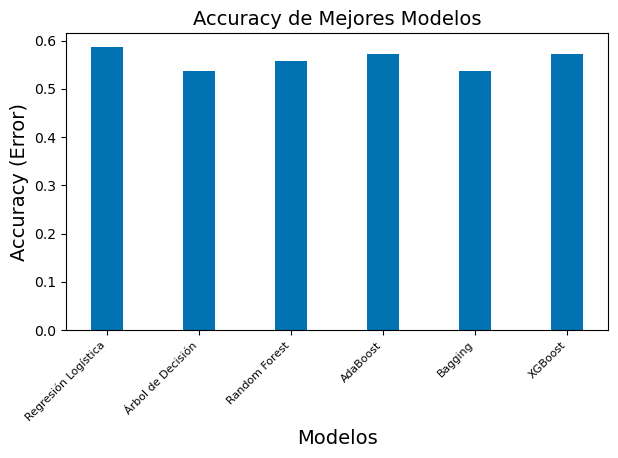

[0.5855855855855856,
 0.536036036036036,
 0.5585585585585585,
 0.5720720720720721,
 0.536036036036036,
 0.5720720720720721]

In [431]:
# Accuracy

# Create figure and axis
fig, ax = plt.subplots()

# Plotting the bars
bar_width = 0.35
ax.bar(classifier_names, classifier_acc, width=bar_width, label=classifier_names)

# Adding labels, title, and legend
ax.set_xlabel('Modelos')
ax.set_ylabel('Accuracy (Error)')
ax.set_title('Accuracy de Mejores Modelos')
ax.set_xticklabels(classifier_names)
ax.set_xticklabels(classifier_names, rotation=45, ha='right', fontsize=8)
#ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

classifier_acc


C:\Users\Diego\AppData\Local\Temp\ipykernel_3088\3640175212.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(classifier_names)
C:\Users\Diego\AppData\Local\Temp\ipykernel_3088\3640175212.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(classifier_names, rotation=45, ha='right', fontsize=8)


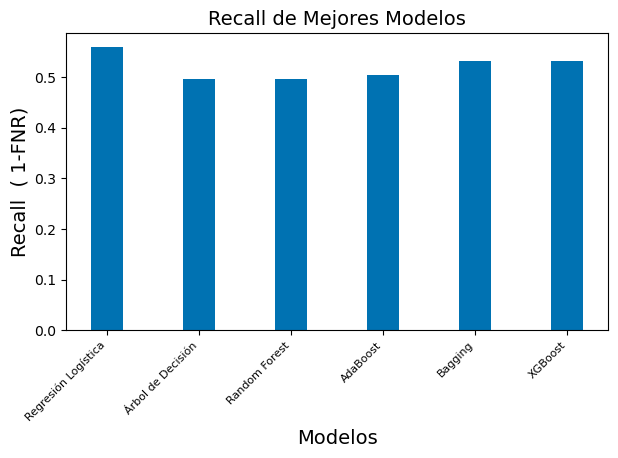

[0.5585585585585585,
 0.4954954954954955,
 0.4954954954954955,
 0.5045045045045045,
 0.5315315315315315,
 0.5315315315315315]

In [433]:
# Recall
# Create figure and axis
fig, ax = plt.subplots()

# Plotting the bars
bar_width = 0.35
ax.bar(classifier_names, classifier_rec, width=bar_width, label=classifier_names)

# Adding labels, title, and legend
ax.set_xlabel('Modelos')
ax.set_ylabel('Recall  ( 1-FNR)')
ax.set_title('Recall de Mejores Modelos')
ax.set_xticklabels(classifier_names)
ax.set_xticklabels(classifier_names, rotation=45, ha='right', fontsize=8)
#ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

classifier_rec


C:\Users\Diego\AppData\Local\Temp\ipykernel_3088\3136764595.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(classifier_names)
C:\Users\Diego\AppData\Local\Temp\ipykernel_3088\3136764595.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(classifier_names, rotation=45, ha='right', fontsize=8)


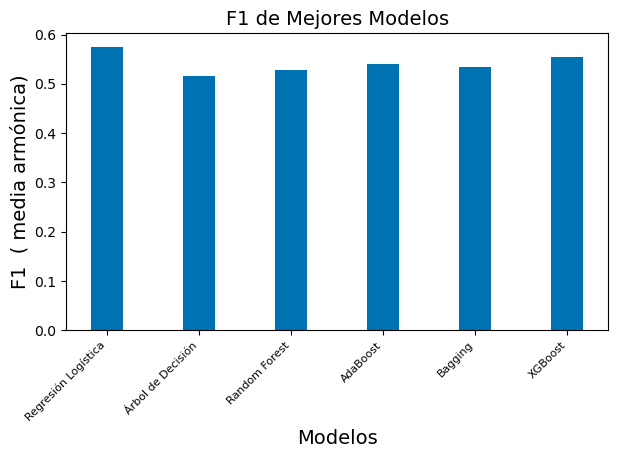

[0.5740740740740741,
 0.5164319248826291,
 0.5288461538461539,
 0.5410628019323671,
 0.5339366515837104,
 0.5539906103286385]

In [434]:
# F1- Score (media armónica entre precisión y recall)
# Create figure and axis
fig, ax = plt.subplots()

# Plotting the bars
bar_width = 0.35
ax.bar(classifier_names, classifier_f1, width=bar_width, label=classifier_names)

# Adding labels, title, and legend
ax.set_xlabel('Modelos')
ax.set_ylabel('F1  ( media armónica)')
ax.set_title('F1 de Mejores Modelos')
ax.set_xticklabels(classifier_names)
ax.set_xticklabels(classifier_names, rotation=45, ha='right', fontsize=8)
#ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

classifier_f1

# DL

# ML Pipelines

In [ ]:
# cargar bases de datos pre-procesadas
x_train = pd.read_csv('data/x_train.csv') 
y_train = pd.read_csv('data/y_train.csv')

x_test = pd.read_csv('data/x_test.csv')
y_test = pd.read_csv('data/y_test.csv')

# quitar primera columna
x_train.pop(x_train.columns[0])
y_train.pop(y_train.columns[0])
x_test.pop(x_test.columns[0])
y_test.pop(y_test.columns[0])


In [ ]:
# extraer nombres de columnas por tipo 
# retorna tupla de listas con nombres de columnas por tipo

def columns_types(data):
    
    # definir estrucutra de datos por tipo de variable
    numeric_types=['int', 'int32', 'int64', 'float', 'float32', 'float64']
    category_types = ['object','category']
    str_types = ['string']
    bool_types = ['bool']
    date_types = ['datetime64', 'datetime', 'datetime64[ns]']
    
    # listas de nombres de variables
    numeric_columns = []
    str_columns = []
    bool_columns = []
    date_columns = []
    category_columns = []

    for column in data.columns:
        
        col_type = str(data[column].dtype)
        
        if any(col_type.startswith(t) for t in numeric_types) or any(col_type.startswith(t) for t in numeric_types):
            numeric_columns.append(column)
        elif any(col_type.startswith(t) for t in str_types):
            str_columns.append(column)
        elif any(col_type.startswith(t) for t in bool_types):
            bool_columns.append(column)
        elif any(col_type.startswith(t) for t in date_types):
            date_columns.append(column)
        elif any(col_type.startswith(t) for t in category_types):
            category_columns.append(column)
            

    return numeric_columns, category_columns, str_columns,bool_columns, date_columns


In [ ]:
# extraer nombres de columnas por tipo 
numeric_columns, category_columns, str_columns,bool_columns, date_columns = columns_types(x)
numeric_columns, category_columns, str_columns,bool_columns, date_columns


(['time_of_day'], ['copy', 'audience', 'keywords'], [], [], [])

In [ ]:
# crear pipeline para variables numericas
# imputador simple por promedio
# escalador estandar 
num_pipeline = make_pipeline(
  SimpleImputer(strategy="mean"),
  StandardScaler())

# crear pipeline para variables categiricas
# imputador simple por moda
# codificador one-hot [0-1]
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))


In [ ]:
# crear ML pipeline 
# variables numéricas: num_pipeline
# variables categóricas: cat_pipeline
preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)


In [ ]:
# crear pipeline end-to-end
# Clasificación (y dependiente: )
# ML pipeline preprocesamiento + random_forest
full_pipeline1 = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestClassifier(random_state=1, n_jobs=-1)),
])

# crear grid de hiper parametros de modelo
param_grid = [
    {'random_forest__n_estimators': [50, 100, 200],
      'random_forest__max_features' : ['sqrt','log2',3,5],
      'random_forest__max_depth' : [2,3,5],
      'random_forest__max_features' : ['sqrt','log2',3,5]
    },
    
    {'random_forest__n_estimators': [200, 300, 150],
      'random_forest__max_features' : [3,5,7],
      'random_forest__max_depth' : [2,3,5],
      'random_forest__max_features' : ['sqrt',3,5]
    }
    
]

# ver lista de parámetros
# pipeline__param 
params_list = list(full_pipeline1.get_params().keys() )
params_list

# GridSearchCV: sintonizador de hiper parametros
# parametros: ML pipeline, grid de hiper parametros, particiones (cv)
# scoring: metrica de evaluación a optimizar
grid_search = GridSearchCV(full_pipeline1, param_grid, cv=5,
                           scoring='recall')

# sintonizar GridSearchCV con datos de entrenamiento
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000026AA930A850>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy...
                                       ('random_forest',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=1))]),
             param_grid=[{'random_forest__max_depth': [2, 3, 5],
                          'random_forest__max_features': ['sqrt', 'log2', 3, 5],
                          'random_forest__n_estimators': [50, 100, 200]},
                         {'random_forest__max_depth': [2, 3, 5],
                          'random_forest__max_features': ['sqrt', 3, 5],
                          'random_forest__n_estimators': [200, 300, 150]}],
             scoring='recall')

In [ ]:
# mejores hiper parametros
grid_search.best_params_

{'random_forest__max_depth': 2,
 'random_forest__max_features': 3,
 'random_forest__n_estimators': 100}

In [ ]:
# mejor ML pipeline1
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000026AA5649B50>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000026AA51EB550>)])),
                ('random_forest',
                 RandomForestClassifier(max_depth=2, max_features=3, n_jobs=-1,
                                        random_state=1))])

In [ ]:
# ver resultados de validación cruzada
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__max_depth,param_random_forest__max_features,param_random_forest__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,0.336600,0.093791,0.090601,0.027695,2,3,100,"{'random_forest__max_depth': 2, 'random_forest...",0.829268,0.855422,0.722892,0.759036,0.819277,0.797179,0.048752,1
41,0.374201,0.026194,0.088599,0.005816,2,3,150,"{'random_forest__max_depth': 2, 'random_forest...",0.792683,0.831325,0.722892,0.771084,0.831325,0.789862,0.040704,2
39,0.530602,0.065967,0.134400,0.030839,2,3,200,"{'random_forest__max_depth': 2, 'random_forest...",0.731707,0.807229,0.710843,0.795181,0.831325,0.775257,0.046062,3
8,0.680600,0.243556,0.146803,0.056475,2,3,200,"{'random_forest__max_depth': 2, 'random_forest...",0.731707,0.807229,0.710843,0.795181,0.831325,0.775257,0.046062,3
6,0.138604,0.001856,0.039201,0.002228,2,3,50,"{'random_forest__max_depth': 2, 'random_forest...",0.719512,0.807229,0.698795,0.795181,0.819277,0.767999,0.049086,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0.427680,0.006030,0.098803,0.003127,5,5,200,"{'random_forest__max_depth': 5, 'random_forest...",0.597561,0.614458,0.602410,0.578313,0.650602,0.608669,0.023983,59
33,0.165003,0.012602,0.043399,0.002245,5,5,50,"{'random_forest__max_depth': 5, 'random_forest...",0.597561,0.614458,0.602410,0.602410,0.626506,0.608669,0.010521,59
35,0.498422,0.064332,0.118602,0.021399,5,5,200,"{'random_forest__max_depth': 5, 'random_forest...",0.597561,0.614458,0.602410,0.578313,0.650602,0.608669,0.023983,59
24,0.338002,0.045052,0.155400,0.124990,5,sqrt,50,"{'random_forest__max_depth': 5, 'random_forest...",0.548780,0.626506,0.638554,0.518072,0.626506,0.591684,0.048747,62


## Evaluación de Modelo

In [ ]:
# extraer mejor modelo de ML pipeline
final_model = grid_search.best_estimator_  # incluye preprocesamiento

# importancia de variables (interpretacion de modelo)
feature_importances = final_model["random_forest"].feature_importances_

# extraer importancia de variables 
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

[(0.20938914946112044, 'pipeline-2__keywords_sale'),
 (0.1672655121151905, 'pipeline-1__time_of_day'),
 (0.054567240228645376, 'pipeline-2__keywords_offer'),
 (0.05284430373356594, 'pipeline-2__audience_adults'),
 (0.051480878180247706, 'pipeline-2__copy_Hurry up!'),
 (0.0498950429496499, 'pipeline-2__copy_Best in town!'),
 (0.04702723861549482, 'pipeline-2__audience_elderly'),
 (0.045165525065012674, 'pipeline-2__keywords_limited'),
 (0.043862436717841166, 'pipeline-2__keywords_bestseller'),
 (0.039264260856499, 'pipeline-2__keywords_exclusive'),
 (0.03781682628431585, 'pipeline-2__keywords_discount'),
 (0.0333524284484973, "pipeline-2__copy_Don't miss out!"),
 (0.03335203150092663, 'pipeline-2__audience_teens'),
 (0.03229940357730321, 'pipeline-2__audience_parents'),
 (0.03151815323702095, 'pipeline-2__copy_Limited offer!'),
 (0.028162066655413785, 'pipeline-2__audience_students'),
 (0.021559675233954537, 'pipeline-2__copy_50% off!'),
 (0.021177827139300262, 'pipeline-2__copy_Buy now

In [ ]:
# generar predicciones
y_pred = cross_val_predict(final_model, x_test, y_test, cv=3)


# métrica de evaluación 'recall'
# validación cruzada: cv=5
cross_val_score(final_model, x_test, y_test, cv=5, scoring="recall")

# matriz de confusión
cm = confusion_matrix(y_test, y_pred)
cm



array([[84, 22],
       [65, 29]], dtype=int64)